Reference: 
 - [BAYESIAN Thompson Sampling, GPs, and Bayesian Optimization](https://gdmarmerola.github.io/ts-for-bayesian-optim/)
 - [stepbystep_opt.ipynb](https://github.com/renato145/bayesian-opt/blob/master/stepbystep_opt.ipynb)
 - [Bayesian Hyperparameter Optimization](https://maelfabien.github.io/machinelearning/HyperOpt/#)
 - [How to Implement Bayesian Optimization from Scratch in Python](https://machinelearningmastery.com/what-is-bayesian-optimization/)

In [1]:
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# suppressing warnings, gp can complain at times
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import norm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# defining the function. At y=0 to get a 1D cut at the origin
def ackley_1d(x, y=0):
    
    # the formula is rather large
    out = (-20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) 
           - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
           + np.e + 20)
    
    return out

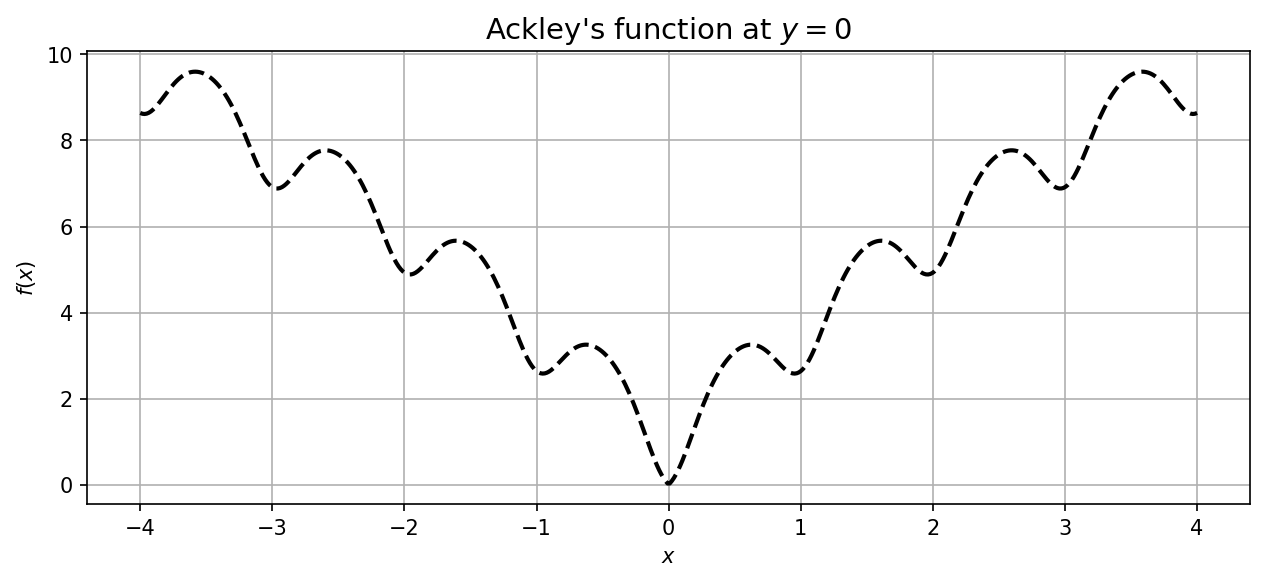

In [3]:
# clearing past figures
plt.close('all')

# let us view the function
plt.figure(figsize=[10,4], dpi=150)

# data
X = np.linspace(-4, 4, 500)
Y = ackley_1d(X)

# plotting
plt.plot(X, Y, 'k--',linewidth=2);
plt.title("""Ackley's function at $y=0$""", fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid()
plt.show()

In [20]:
# let us draw 20 random samples of the Ackley's function
x_observed = np.random.uniform(-4, 4, 20)
y_observed = ackley_1d(x_observed)

# let us use the Matern kernel
# K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
K = None
# instance of GP
gp = GaussianProcessRegressor(kernel=K)

# fitting the GP
gp.fit(x_observed.reshape(-1, 1), y_observed)

GaussianProcessRegressor()

In [21]:
# let us check the learned model over all of the input space
X_ = np.linspace(-4, 4, 500)
y_mean, y_std = gp.predict(X_.reshape(-1, 1), return_std=True)

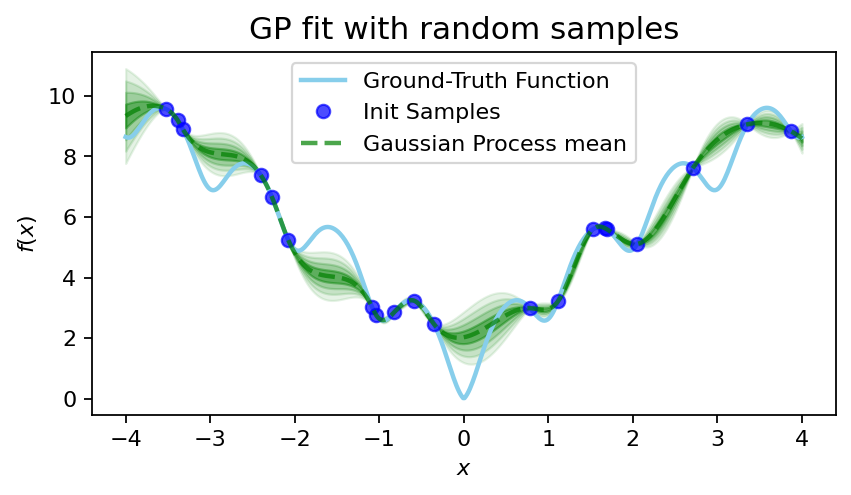

In [13]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[6, 3], dpi=160)

# data
Y = ackley_1d(X_)

# plotting
plt.plot(X_, Y, 'skyblue', linewidth=2, label='Ground-Truth Function')
plt.plot(x_observed, y_observed, 'bo', label="""Init Samples""", alpha=0.7)
plt.plot(X_, y_mean, 'g--', linewidth=2, label='Gaussian Process mean', alpha=0.7)
for s in [0.25, 0.5, 0.74, 1.00]:
    plt.fill_between(X_, y_mean - s*y_std, y_mean + s*y_std, alpha=0.1/s, color='green')
plt.title("""GP fit with random samples""", fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

In [24]:
# function samples
y_samples = gp.sample_y(X_.reshape(-1,1), 10)

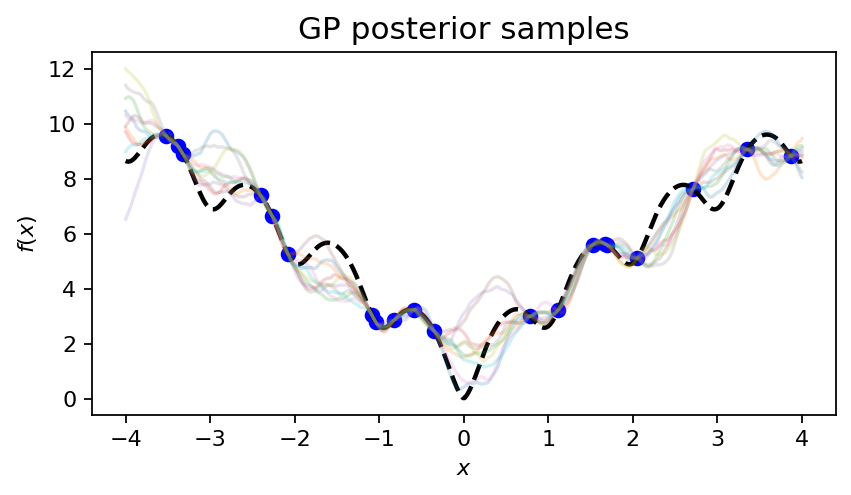

In [16]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[6, 3], dpi=160)

# plotting random observations of function
plt.plot(x_observed, y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=1.0)
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');


# plotting all the posteriors
for posterior_sample in y_samples.T:
    plt.plot(X_, posterior_sample, alpha=0.2, linewidth=1.5, label="""Random Samples of Ackley's function""")

# title and labels    
plt.title("""GP posterior samples""", fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

In [ ]:
def PI(x, gp, y_max, xi):
    mean, std = gp.predict(x, return_std=True)
    z = (mean - y_max - xi)/std
    return norm.cdf(z)
def EI(x, gp, y_max, xi):
    mean, std = gp.predict(x, return_std=True)
    a = (mean - y_max - xi)
    z = a / std
    return a * norm.cdf(z) + std * norm.pdf(z)
def UCB(x, gp, kappa):
    mean, std = gp.predict(x, return_std=True)
    return mean + kappa * std

def acq_max(ac, gp, y_max, bounds, random_state, num=10000):
    x_tries = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num, bounds.shape[0]))
    acquisition = ac(x_tries, gp=gp, y_max=y_max)
    argmax_x = x_tries[acquisition.argmax()]
    max_acq = acquisition.max()
    return argmax_x, max_acq, acquisition

In [ ]:
class GaussianProcessSmapler(object):
    def __init__(self, search_space, total_trial, init_trial):
        self.search_space = search_space
        self.total_trial = total_trial
        self.init_trial = init_trial

    def __iter__(self):
        pass
    def __next__(self):
        pass

In [15]:
# our TS-GP optimizer
class ThompsonSamplingGP:
    
    # initialization
    def __init__(self, n_random_draws, objective, x_bounds, interval_resolution=1000):
                
        # number of random samples before starting the optimization
        self.n_random_draws = n_random_draws
        
        # the objective is the function we're trying to optimize
        self.objective = objective
        
        # the bounds tell us the interval of x we can work
        self.bounds = x_bounds
        
        # interval resolution is defined as how many points we will use to 
        # represent the posterior sample
        # we also define the x grid
        self.interval_resolution = interval_resolution
        self.X_grid = np.linspace(self.bounds[0], self.bounds[1], self.interval_resolution)
        
        # also initializing our design matrix and target variable
        self.X = np.array([]); self.y = np.array([])

    # fitting process
    def fit(self, X, y):
        
        # let us use the Matern kernel
        K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

        # instance of GP
        gp = GaussianProcessRegressor(kernel=K)

        # fitting the GP
        gp.fit(X, y)
        
        # return the fitted model
        return gp

    # process of choosing next point
    def choose_next_sample(self):
        
        # if we do not have enough samples, sample randomly from bounds
        if self.X.shape[0] < self.n_random_draws:
            next_sample = np.random.uniform(self.bounds[0], self.bounds[1], 1)[0]
        
        # if we do, we fit the GP and choose the next point based on the posterior draw minimum
        else:
            # 1. Fit the GP to the observations we have
            self.gp = self.fit(self.X.reshape(-1,1), self.y)
            
            # 2. Draw one sample (a function) from the posterior
            posterior_sample = self.gp.sample_y(self.X_grid.reshape(-1,1), 1).T[0]
            
            # 3. Choose next point as the optimum of the sample
            which_min = np.argmin(posterior_sample)
            next_sample = self.X_grid[which_min]
        
            # let us also get the std from the posterior, for visualization purposes
            posterior_mean, posterior_std = self.gp.predict(self.X_grid.reshape(-1,1), return_std=True)
        
        # let us observe the objective and append this new data to our X and y
        next_observation = self.objective(next_sample)
        self.X = np.append(self.X, next_sample)
        self.y = np.append(self.y, next_observation)
        
        # return everything if possible
        try:
            # returning values of interest
            return self.X, self.y, self.X_grid, posterior_sample, posterior_mean, posterior_std
        
        # if not, return whats possible to return
        except:
            return (self.X, self.y, self.X_grid, np.array([np.mean(self.y)]*self.interval_resolution), 
                    np.array([np.mean(self.y)]*self.interval_resolution), np.array([0]*self.interval_resolution))

In [23]:
# function to create an animation with the visualization
def ts_gp_animation_ackley(ts_gp, max_rounds):
    
    # dict for accumulating runs
    round_dict = {}
    
    # loop for each round
    for round_id in range(max_rounds):
        
        # recording all the info
        X_observed, y_observed, X_grid, posterior_sample, posterior_mean, posterior_std = ts_gp.choose_next_sample()
        
        # adding to dict
        round_dict[round_id] = {'X_observed': X_observed, 
                                'y_observed': y_observed, 
                                'X_grid': X_grid,
                                'posterior_sample': posterior_sample,
                                'posterior_mean': posterior_mean,
                                'posterior_std': posterior_std}
        # print(round_dict[round_id])
        print(round_id)

    # plotting!
    fig, ax = plt.subplots(figsize=[10,4], dpi=150)
    
    # plotting first iteration
    ax.plot(X, Y, 'k--', linewidth=2, label='Actual function');
    ax.plot(round_dict[0]['X_observed'], round_dict[0]['y_observed'], 'bo', label="""GP-Chosen Samples of Ackley's function""", alpha=0.7)
    ax.plot(round_dict[0]['X_grid'], round_dict[0]['posterior_sample'], 'r', linewidth=2, label='Sample from the posterior', alpha=0.7)
    ax.fill_between(round_dict[0]['X_grid'], round_dict[0]['posterior_mean'] - round_dict[0]['posterior_std'],
                     round_dict[0]['posterior_mean'] + round_dict[0]['posterior_std'], alpha=0.2, color='r')
    plt.title("""Ackley's function at $y=0$, TS-GP optimization""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$'); 
    ax.set_ylim(-0.5, 10);
        
    # function for updating
    def animate(i):
        ax.clear()
        ax.plot(X, Y, 'k--', linewidth=2, label='Actual function');
        ax.plot(round_dict[i]['X_observed'], round_dict[i]['y_observed'], 'bo', label="""GP-Chosen Samples of Ackley's function""", alpha=0.7)
        ax.plot(round_dict[i]['X_grid'], round_dict[i]['posterior_sample'], 'r', linewidth=2, label='Sample from the posterior', alpha=0.7)
        ax.fill_between(round_dict[i]['X_grid'], round_dict[i]['posterior_mean'] - round_dict[i]['posterior_std'],
                         round_dict[i]['posterior_mean'] + round_dict[i]['posterior_std'], alpha=0.2, color='r')
        plt.title("""Ackley's function at $y=0$, TS-GP optimization""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
        ax.set_ylim(-0.5, 10);
        return ()

    # function for creating animation
    anim = animation.FuncAnimation(fig, animate, frames=max_rounds, interval=1000, blit=True)

    # writergif = animation.PillowWriter(fps=1)
    # anim.save("test.gif" , writer=writergif)

    # showing
    return anim

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


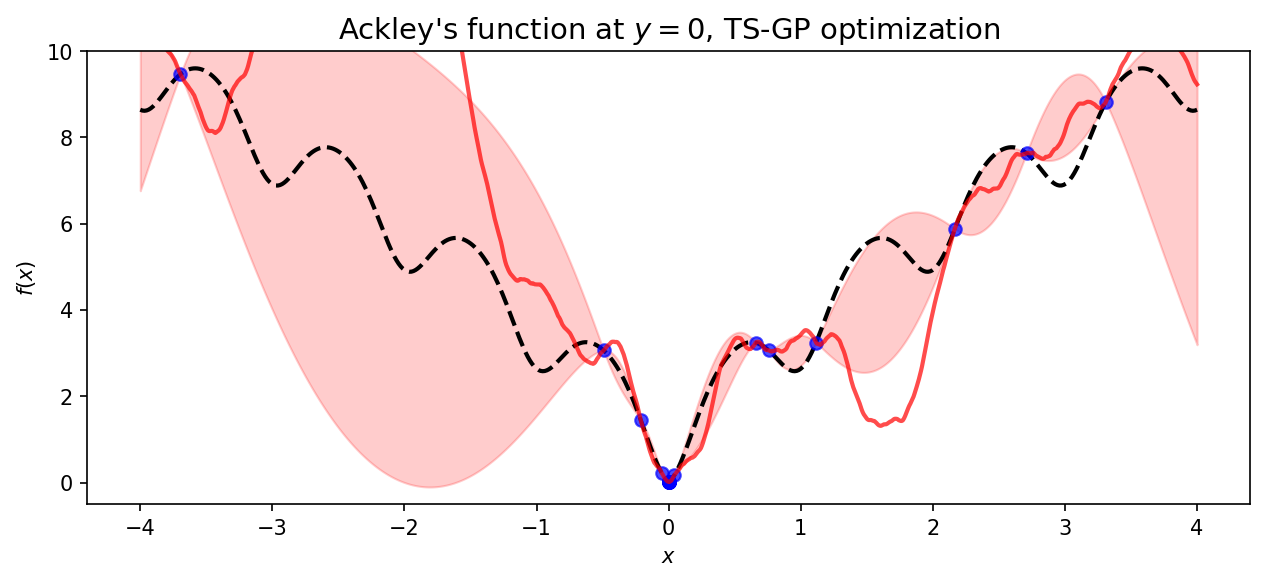

In [24]:
# instance of our TS-GP
ts_gp = ThompsonSamplingGP(n_random_draws=8, objective=ackley_1d, x_bounds=(-4,4))

# showing animnation
anim = ts_gp_animation_ackley(ts_gp, 20)

writergif = animation.PillowWriter(fps=1)
anim.save("test.gif" , writer=writergif)

In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize

def acq_max(ac, gp, y_max, bounds, opt_type ='l_bfgs_b', num_ini = 10, num_ini_exp=1000):
    """
    A function to find the maximum of the acquisition function
    It uses a combination of random sampling (cheap) and the 'L-BFGS-B'
    optimization method. First by sampling 1e5 points at random, and then
    running L-BFGS-B from 250 random starting points.
    Parameters
    ----------
    :param ac:
        The acquisition function object that return its point-wise value.
    :param gp:
        A gaussian process fitted to the relevant data.
    :param y_max:
        The current maximum known value of the target function.
    :param bounds:
        The variables bounds to limit the search of the acq max.
    Returns
    -------
    :return: x_max, The arg max of the acquisition function.
    """

    # Warm up with random points  
    x_tries = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_ini_exp, bounds.shape[0]))        
    ys = ac(x_tries, gp=gp, y_max=y_max)
    x_max = x_tries[ys.argmax()]
    max_acq = ys.max()
        
    # Explore the parameter space more throughly
    x_seeds = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_ini, bounds.shape[0]))

    if opt_type=='l_bfgs_b':
        for x_try in x_seeds:
            # Find the minimum of minus the acquisition function
            res = minimize(lambda x: -ac(x.reshape(1, -1), gp=gp, y_max=y_max), x_try.reshape(1, -1), bounds=bounds, method="L-BFGS-B")    
            # Store it if better than previous minimum(maximum).
            if max_acq is None or -res.fun[0] >= max_acq:
                x_max = res.x
                max_acq = -res.fun[0]
         
        # Clip output to make sure it lies within the bounds. Due to floating
        # point technicalities this is not always the case.
        return np.clip(x_max, bounds[:, 0], bounds[:, 1])
    else:
        # Clip output to make sure it lies within the bounds. Due to floating
        # point technicalities this is not always the case.
        return np.clip(x_max, bounds[:, 0], bounds[:, 1])